In [28]:
import pandas as pd
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [29]:
df = pd.read_csv("train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
target = "label"
X_train = df[df.columns.drop(target)]
y_train = df[[target]].copy()
y_train.head()

,label
0,1
1,0
2,1
3,4
4,0


In [68]:
for i in range(10):
    y_train[f"is_number_{i}"] = (y_train["label"] == i) .astype(np.int64)
y_train = y_train.drop(columns=["label"])
y_train.head()

,is_number_0,is_number_1,is_number_2,is_number_3,is_number_4,is_number_5,is_number_6,is_number_7,is_number_8,is_number_9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [69]:
X_train = np.array(X_train).reshape(X_train.shape[0], 28, 28, 1)
y_train = np.array(y_train).reshape(y_train.shape[0], 10)
print(X_train.shape)
print(y_train.shape)

(42000, 28, 28, 1)
(42000, 10)


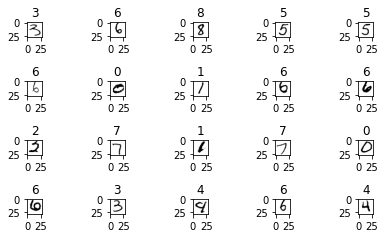

In [70]:
labels_show = np.array(df.label)
for i in range(20):
    plt.subplot(5,5,i+1)
    index = np.random.randint(0,42000)
    plt.imshow(X_train[index], cmap = 'Greys')
    plt.title(labels_show[index])
plt.tight_layout()

In [73]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import layers
from scikeras.wrappers import KerasClassifier

model = Sequential([
	layers.Conv2D(filters = 32, kernel_size=3, activation="relu", padding='same', input_shape=(28, 28, 1)),
	layers.MaxPool2D(),
	layers.Conv2D(filters = 64, kernel_size=3, padding = 'same', activation ='relu'),
	layers.MaxPool2D(),
	layers.Dropout(0.25),

	# Classifier Head
	layers.Flatten(),
	layers.Dense(256, activation = "relu"),
	layers.Dropout(0.5),
	layers.Dense(10, activation = "softmax"),
])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten_11 (Flatten)        (None, 3136)             

In [74]:
clf_model = KerasClassifier(model, epochs=20, batch_size=50, verbose=1, validation_split=0.1)
clf_model.fit(X_train, y_train)

Epoch 1/20
756/756 [==============================] - ETA: 0s - loss: 0.8691 - accuracy: 0.8962

In [ ]:
X_test = pd.read_csv("test.csv")
X_test = np.array(X_test).reshape(X_test.shape[0], 28, 28, 1)
y_test = clf_model.predict_proba(X_test)
ans = pd.DataFrame({'ImageId':[],'Label':[]})
for i in range(0,len(y_test)):
    id = i+1
    label = np.argmax(y_test[i])
    tmp = pd.DataFrame({'ImageId':[id],'Label':[label]})
    ans = ans.append(tmp, ignore_index = True)

In [48]:
ans['ImageId'] = ans['ImageId'].astype(int)
ans['Label'] = ans['Label'].astype(int)
ans.to_csv('cnn.csv', index=False) #change name here
ans.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
